<a href="https://colab.research.google.com/github/PhillippeJ/ModSimPy/blob/master/Creditas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Creditas Loan Charge-offs from Loan Financial Dataset

***By Phillippe Jardim***

*** March 10, 2023 ***

*** Revision date Sept 13, 2013 ***

## Work Content

# 1. Introduction
<a id="1"></a>

[Creditas] is a digital loan plataform.

> Creditas provides financial services and loans for businesses and private individuals. The current portfolio includes three different products. Clients can apply for loans directly on their website and select the preferable loan. Creditas collect information provided by their prospective clients, such as the amount of loan, loan grade, and loan purpose. The company profits from the interest applied on the loan plus a service fee.


This project aims to build a machine-learning model to predict the probability of a loan default. I will use the data available in the LMS (Learning Management System), including financial and demographic data from clients and information regarding the loan provided. The predictive model must assist the decision-making process, mitigating the risks involved. For this project, I will only consider loans approved by the standard procedure policy adopted in the company.


# 2. Importing the Data
<a id="2"></a>

In [369]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Pandas options
pd.set_option('display.max_colwidth', 1000, 'display.max_rows', None, 'display.max_columns', None)

# Plotting options
%matplotlib inline
mpl.style.use('ggplot')
sns.set(style='whitegrid')
loans = pd.read_csv('accepted_2007_to_2018Q4.csv',  low_memory=False)



In [370]:

del loans['url']


In [371]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2223624 entries, 0 to 2223623
Columns: 150 entries, id to settlement_term
dtypes: float64(113), object(37)
memory usage: 2.5+ GB


As observed, the dataset is dense, containing about 2M+ rows and 150 features.

> Dataset size 2.5 GB

Let's take glance on the dataset

In [372]:
loans.sample(5)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
2034664,83973579,NaN,16000.0,16000.0,16000.0,60 months,11.49,351.81,B,B5,Technician,10+ years,RENT,47000.0,Verified,Jul-2016,Fully Paid,n,NaN,debt_consolidation,Debt consolidation,183xx,PA,24.28,0.0,Mar-2006,665.0,669.0,0.0,54.0,NaN,11.0,0.0,8758.0,43.6,15.0,w,0.00,0.00,17733.021857,17733.02,16000.00,1733.02,0.0,0.0,0.0,Jul-2017,13873.32,NaN,Nov-2017,669.0,665.0,0.0,54.0,1.0,Individual,NaN,NaN,NaN,0.0,635.0,20026.0,0.0,3.0,0.0,2.0,13.0,11268.0,50.0,0.0,3.0,3022.0,47.0,20100.0,0.0,0.0,0.0,5.0,2003.0,4289.0,62.4,0.0,0.0,43.0,123.0,13.0,13.0,1.0,13.0,NaN,20.0,NaN,1.0,4.0,6.0,5.0,6.0,3.0,8.0,10.0,6.0,11.0,0.0,0.0,0.0,0.0,86.7,0.0,0.0,0.0,42760.0,20026.0,11400.0,22660.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
348615,41940273,NaN,25000.0,25000.0,25000.0,60 months,10.99,543.44,B,B4,Rn,10+ years,RENT,80000.0,Source Verified,Mar-2015,Fully Paid,n,NaN,debt_consolidation,Debt consolidation,959xx,CA,14.07,0.0,Aug-1992,725.0,729.0,0.0,NaN,NaN,7.0,0.0,22004.0,83.0,24.0,w,0.00,0.00,31664.314631,31664.31,25000.00,6664.31,0.0,0.0,0.0,Jun-2018,10974.14,NaN,Mar-2019,724.0,720.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,464811.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26500.0,NaN,NaN,NaN,5.0,66402.0,3249.0,85.9,0.0,0.0,174.0,271.0,7.0,5.0,6.0,35.0,NaN,7.0,NaN,0.0,2.0,4.0,2.0,3.0,8.0,4.0,10.0,4.0,7.0,0.0,0.0,0.0,4.0,100.0,50.0,0.0,0.0,477456.0,48649.0,23000.0,28907.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

# 3. Dependent Variable
<a id="3"></a>

Checking the correlations between the variables.

In [373]:
loans['loan_status'].value_counts(dropna=False)

Fully Paid                                             1060284
Current                                                 863327
Charged Off                                             263683
Late (31-120 days)                                       20994
In Grace Period                                           8266
Late (16-30 days)                                         4250
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     39
NaN                                                         32
Name: loan_status, dtype: int64

To initiate our analysis, I am considering only the "fully paid" or "Charge off" loans, disregarding any loans that are not completed. This includes present loans, defaulted loans, missing status, and loans failing to meet the credit policy criteria.

In [374]:
loans = loans.loc[loans['loan_status'].isin(['Fully Paid', 'Charged Off'])]

In [375]:
loans.shape

(1323967, 150)


The sample constitute of 1,323,967 loans.



In [376]:
loans['loan_status'].value_counts(normalize=True, dropna=False)

Fully Paid     0.800839
Charged Off    0.199161
Name: loan_status, dtype: float64


About 80% of the sample correspond to fully paid loans while 19.9% have charge off. Those results lead us to an imbalanced classification problem.
```



# 4. Feature Engineering
<a id="4"></a>

The process designed for feature selection will take into consideration the following criteria.

1. Features containing more than 30% of their data missing will be discarded.
2. It will be considered the features only available for the decision-making process to assess the denial or acceptance of the loan.

## 4.1 Dropping features = > 30% missing value
<a id="4.1"></a>

In [377]:
missing_fractions = loans.isnull().mean().sort_values(ascending=False)
missing_fractions.head(15)

next_pymnt_d                                  1.000000
member_id                                     1.000000
orig_projected_additional_accrued_interest    0.997249
hardship_amount                               0.995806
hardship_type                                 0.995806
hardship_reason                               0.995806
hardship_status                               0.995806
deferral_term                                 0.995806
hardship_start_date                           0.995806
hardship_end_date                             0.995806
payment_plan_start_date                       0.995806
hardship_length                               0.995806
hardship_dpd                                  0.995806
hardship_loan_status                          0.995806
hardship_payoff_balance_amount                0.995806
dtype: float64

Understanding the distribution of Missing values on the features
**VIZ:**

Text(0, 0.5, 'Feature Number')

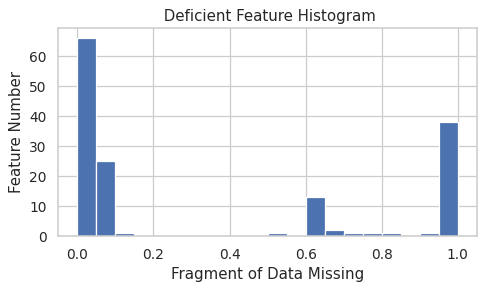

In [378]:
plt.figure(figsize=(6,3), dpi=90)
missing_fractions.plot.hist(bins=20)
plt.title(' Deficient Feature Histogram')
plt.xlabel('Fragment of Data Missing')
plt.ylabel('Feature Number')

As observed in the graphic, a large portion of the data is completed. However, we see a significant amount of missing values on features (See the right side of the histogram). I will classify those features and eliminate them.

In [379]:
drop_list = sorted(list(missing_fractions[missing_fractions > 0.3].index))
print(drop_list)

# Quantity of features eliminated in the process
len(drop_list)

['all_util', 'annual_inc_joint', 'debt_settlement_flag_date', 'deferral_term', 'desc', 'dti_joint', 'hardship_amount', 'hardship_dpd', 'hardship_end_date', 'hardship_last_payment_amount', 'hardship_length', 'hardship_loan_status', 'hardship_payoff_balance_amount', 'hardship_reason', 'hardship_start_date', 'hardship_status', 'hardship_type', 'il_util', 'inq_fi', 'inq_last_12m', 'max_bal_bc', 'member_id', 'mths_since_last_delinq', 'mths_since_last_major_derog', 'mths_since_last_record', 'mths_since_rcnt_il', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq', 'next_pymnt_d', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'open_rv_12m', 'open_rv_24m', 'orig_projected_additional_accrued_interest', 'payment_plan_start_date', 'revol_bal_joint', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'sec_app_earliest_cr_line', 'sec_app_fico_range_high', 'sec_app_fico_range_low', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_mths_since_last_ma

58

In [380]:
loans.drop(labels=drop_list, axis=1, inplace=True)
loans.shape

(1323967, 92)

## 4.2 Selecting the Features for Decision Making.
<a id="4.2"></a>

Given the instructions on the loan analysis described in the Creditas Standard Operational Procedure, follow the component class below.


In [381]:
print(sorted(loans.columns))

['acc_now_delinq', 'acc_open_past_24mths', 'addr_state', 'annual_inc', 'application_type', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'collection_recovery_fee', 'collections_12_mths_ex_med', 'debt_settlement_flag', 'delinq_2yrs', 'delinq_amnt', 'disbursement_method', 'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 'fico_range_low', 'funded_amnt', 'funded_amnt_inv', 'grade', 'hardship_flag', 'home_ownership', 'id', 'initial_list_status', 'inq_last_6mths', 'installment', 'int_rate', 'issue_d', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'last_pymnt_amnt', 'last_pymnt_d', 'loan_amnt', 'loan_status', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sa

The features available for loan analysis are those pertinent to demographic and monetary, such as borrower address, annual income, loan grade, and loan interest.

In [382]:
decision_features = ['addr_state', 'annual_inc', 'application_type', 'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 'fico_range_low', 'grade', 'home_ownership', 'id', 'initial_list_status', 'installment', 'int_rate', 'issue_d', 'loan_amnt', 'loan_status', 'mort_acc', 'open_acc', 'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'revol_bal', 'revol_util', 'sub_grade', 'term', 'title', 'total_acc', 'verification_status', 'zip_code']

In [383]:
len(decision_features)

31

Eliminating any feature not belonging to decision_features

In [384]:
drop_list = [col for col in loans.columns if col not in decision_features]
print(drop_list)
len(drop_list)
loans.drop(labels=drop_list, axis=1, inplace=True)

['funded_amnt', 'funded_amnt_inv', 'pymnt_plan', 'delinq_2yrs', 'inq_last_6mths', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'policy_code', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75'

61 features were deleted in total.

In [385]:
loans.shape

(1323967, 31)

# 5. Exploratory Data Analysis and Pre-processing
<a id="5"></a>

During this process, following the CRISP-DM frame, I will perform the following tasks:

0. Analyze each feature separately;
1. Drop irrelevant features for predicting the loan status.
2. Deploy statistical analysis and VIZ against the loan status.
3. Manipulate features to increase the model's performance, if necessary.


In [386]:
# Defining a function for plotting a variable and comparing with the loan status
def plot_var(col_name, full_name, continuous):
    """
    Visualize a variable with and without faceting on the loan status.
    - col_name is the variable name in the dataframe
    - full_name is the full variable name
    - continuous is True if the variable is continuous, False otherwise
    """
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=100)

    # Plot without loan status
    if continuous:
        sns.distplot(loans.loc[loans[col_name].notnull(), col_name], kde=False, ax=ax1)
    else:
        sns.countplot(loans[col_name], order=loans[col_name].unique(), color='#5975A4', saturation=1, ax=ax1)
    ax1.set_xlabel(full_name)
    ax1.set_ylabel('Count')
    ax1.set_title(full_name)

    # Plot with loan status
    if continuous:
        sns.boxplot(x=col_name, y='loan_status', data=loans, ax=ax2)
        ax2.set_ylabel('')
        ax2.set_title(full_name + ' by Loan Status')
    else:
        charge_off_rates = loans.groupby(col_name)['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']
        sns.barplot(x=charge_off_rates.index, y=charge_off_rates.values, color='#5975A4', saturation=1, ax=ax2)
        ax2.set_ylabel('Fraction of Loans Charged-off')
        ax2.set_title('Charge-off Rate by ' + full_name)
    ax2.set_xlabel(full_name)

    plt.tight_layout()


In [387]:
print(list(loans.columns))

['id', 'loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'earliest_cr_line', 'fico_range_low', 'fico_range_high', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'application_type', 'mort_acc', 'pub_rec_bankruptcies']


# 5.1 - ID

A unique Identification for the loan listing

In [388]:
loans['id'].sample(5)

481773     128404222
1190242     27841980
1877205      3240040
204124      55877263
1032972     73763540
Name: id, dtype: object

In [389]:
# Perhaps, Do we have duplicates?
loans['id'].describe()

count      1323967
unique     1323967
top       68407277
freq             1
Name: id, dtype: object

As observed, we do not have any duplicates. IDs won't be helpful for modeling once they do not possess significance for categorical or numerical values.


In [390]:
loans.drop('id', axis=1, inplace=True)

# 5.2 - loan_amnt

The listed amount of the loan applied for by the
borrower

In [391]:
loans['loan_amnt'].describe()

count    1.323967e+06
mean     1.442680e+04
std      8.710564e+03
min      5.000000e+02
25%      8.000000e+03
50%      1.200000e+04
75%      2.000000e+04
max      4.000000e+04
Name: loan_amnt, dtype: float64

Loan amount parameter ($):

0. MAX: 40,000
1.  MED: 12,000
2.  MIN: 500

<ipython-input-386-96cfd28b45d5>:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(loans.loc[loans[col_name].notnull(), col_name], kde=False, ax=ax1)


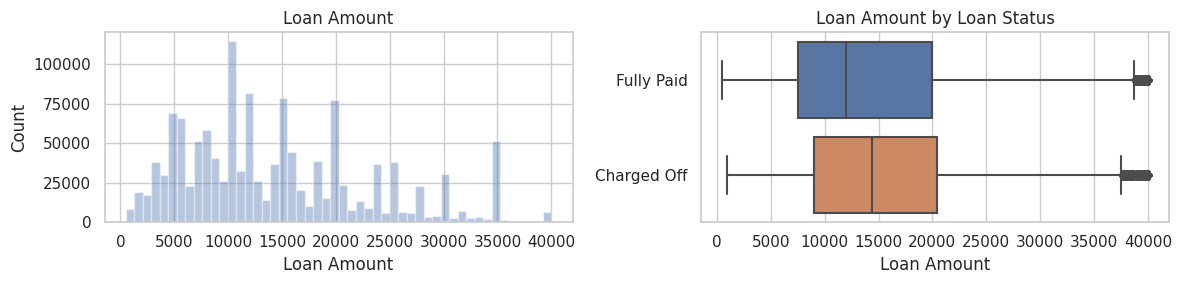

In [392]:
plot_var('loan_amnt', 'Loan Amount', continuous=True)

Based on the indication in the graphics, Charge-off loans tend to occur with higher loan amounts.

In [393]:
loans.groupby('loan_status')['loan_amnt'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,263683.0,15577.926051,8805.521053,900.0,9000.0,14400.0,20425.0,40000.0
Fully Paid,1060284.0,14140.520794,8663.074671,500.0,7500.0,12000.0,20000.0,40000.0


# 5.3 - Term

The number of montly payments on the loan. 36 or 60 months (3 and 5 years).

In [394]:
loans['term'].value_counts(dropna=False)

 36 months    1004048
 60 months     319919
Name: term, dtype: int64

In [395]:
# Check the Statistical proportion on each class
loans['term'] = loans['term'].apply(lambda s: np.int8(s.split()[0]))

In [396]:
loans['term'].value_counts(normalize=True)

36    0.758363
60    0.241637
Name: term, dtype: float64

In [397]:
# Payment default by period of time
loans.groupby('term')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']

term
36    0.159205
60    0.324563
Name: loan_status, dtype: float64

As observed, 75% of the completed loans occur within 36 months, while 24% occur within 60. Longer installments have double chances to be defaulted.

# 5.4 - int_rate

Interest rate on the loan

In [398]:
loans['int_rate'].describe()

count    1.323967e+06
mean     1.322854e+01
std      4.762870e+00
min      5.310000e+00
25%      9.750000e+00
50%      1.274000e+01
75%      1.599000e+01
max      3.099000e+01
Name: int_rate, dtype: float64

<ipython-input-386-96cfd28b45d5>:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(loans.loc[loans[col_name].notnull(), col_name], kde=False, ax=ax1)


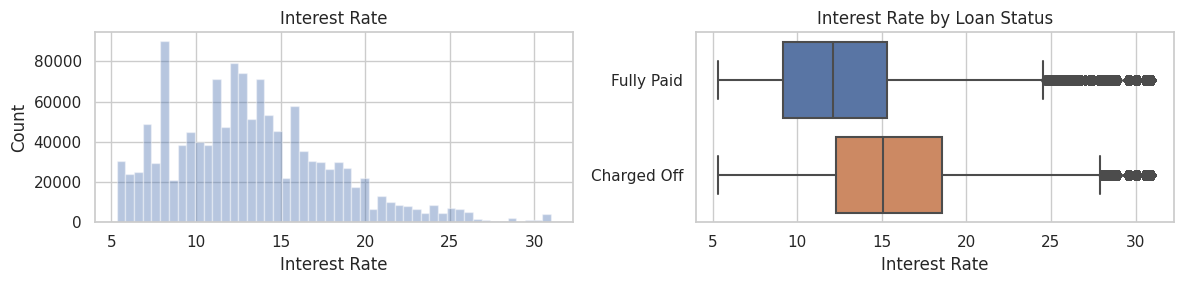

In [399]:
plot_var('int_rate', 'Interest Rate', continuous=True)

Interest Rate parameter (%):

0.  MAX: 30.99
1.  MED: 12.74
2.  MIN: 5.31

> Charge-off loans tend to have much higher interest rates.

In [400]:
loans.groupby('loan_status')['int_rate'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,263683.0,15.701065,4.899834,5.31,12.29,15.05,18.55,30.99
Fully Paid,1060284.0,12.613640,4.522983,5.31,9.17,12.13,15.31,30.99


# 5.5 - Installments

The monthly payment owed by the borrower if loan is funded

In [401]:
loans['installment'].describe()

count    1.323967e+06
mean     4.381032e+02
std      2.611466e+02
min      4.930000e+00
25%      2.488200e+02
50%      3.754300e+02
75%      5.807000e+02
max      1.719830e+03
Name: installment, dtype: float64

<ipython-input-386-96cfd28b45d5>:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(loans.loc[loans[col_name].notnull(), col_name], kde=False, ax=ax1)


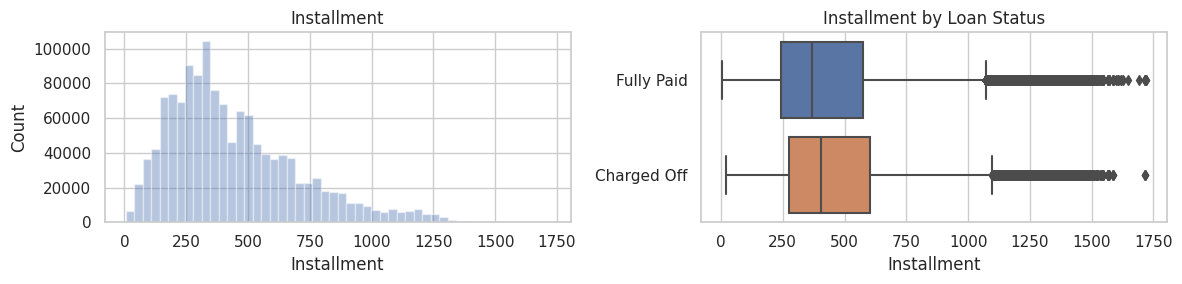

In [402]:
plot_var('installment', 'Installment', continuous=True)

In [403]:
loans.groupby('loan_status')['installment'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,263683.0,465.122400,262.196628,21.62,275.75,403.12,604.8650,1717.63
Fully Paid,1060284.0,431.383803,260.450042,4.93,241.01,368.45,573.1325,1719.83


Installment parameter ($):

0.  MAX: 1719.83
1.  MED: 375.48
2.  MIN: 4.93

> Charge-off loans tend to have higher installments and an additional $ 33.73 on average in the bill compared with fully paid installments.

# 5.6 - Grade and Sub_grade

Loan category

In [404]:
# Checking the Values for grade and sub-grade
print(sorted(loans['grade'].unique()))
print(sorted(loans['sub_grade'].unique()))

['A', 'B', 'C', 'D', 'E', 'F', 'G']
['A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1', 'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3', 'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5']


Sub-grade is a classification of Grade "as sub levels".

In [405]:
# Dropping Grade feature
loans.drop('grade', axis=1, inplace=True)

In [406]:
loans['sub_grade'] = pd.Series(loans['sub_grade'])

In [407]:
category = pd.DataFrame(loans['sub_grade'] == pd.Series(loans['sub_grade']))


# 5.7 - Emp_title

Borrower employment title


In [408]:
loans['emp_title'].describe()

count     1239476
unique     374707
top       Teacher
freq        20920
Name: emp_title, dtype: object

Given the amount of 374707 different job titles this feature is not going to be useful. feature Dropped.

In [409]:
loans.drop(labels='emp_title', axis=1, inplace=True)


# 5.8 - Emp_lenght

Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years

In [410]:
loans['emp_length'].value_counts(dropna=False).sort_index()

1 year        87089
10+ years    434822
2 years      119715
3 years      105906
4 years       79240
5 years       82808
6 years       61753
7 years       58980
8 years       59827
9 years       50092
< 1 year     106474
NaN           77261
Name: emp_length, dtype: int64

In [411]:
# 2489 Missing values NaN
# converting employment lenght into int
loans['emp_length'].replace(to_replace='10+ years', value='10 years', inplace=True)

In [412]:
loans['emp_length'].replace('< 1 year', '0 years', inplace=True)

In [413]:
def emp_length_to_int(s):
    if pd.isnull(s):
        return s
    else:
        return np.int8(s.split()[0])

In [414]:
loans['emp_length'] = loans['emp_length'].apply(emp_length_to_int)

In [415]:
loans['emp_length'].value_counts(dropna=False).sort_index()

0.0     106474
1.0      87089
2.0     119715
3.0     105906
4.0      79240
5.0      82808
6.0      61753
7.0      58980
8.0      59827
9.0      50092
10.0    434822
NaN      77261
Name: emp_length, dtype: int64

In [416]:

jobtime = pd.DataFrame(loans['emp_length'].value_counts(dropna=False).sort_index())


In [417]:
jobtime.head(11)


,emp_length
0.0,106474
1.0,87089
2.0,119715
3.0,105906
4.0,79240
5.0,82808
6.0,61753
7.0,58980
8.0,59827
9.0,50092


<ipython-input-386-96cfd28b45d5>:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(loans.loc[loans[col_name].notnull(), col_name], kde=False, ax=ax1)


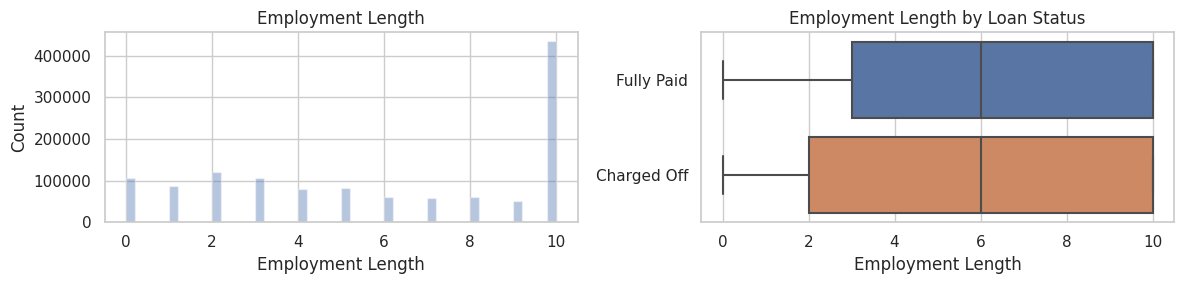

In [418]:
loans = loans.assign(jobtime=loans['emp_length'])
plot_var('jobtime', 'Employment Length', continuous=True)

The data does not tend to variate with time employed.

# 5.9 - Home Ownership

The home ownership status provided by the borrower during registration or obtained from the credit report. the values are classified as: RENT, OWN, MORTGAGE, OTHER.

In [419]:
loans['home_ownership'].value_counts(dropna=False)

MORTGAGE    654805
RENT        526303
OWN         142384
ANY            283
OTHER          144
NONE            48
Name: home_ownership, dtype: int64

In [420]:
loans['home_ownership'].replace(['NONE', 'ANY'], 'OTHER', inplace=True)
loans['home_ownership'].value_counts(dropna=False)

MORTGAGE    654805
RENT        526303
OWN         142384
OTHER          475
Name: home_ownership, dtype: int64

In [421]:
# compare loan status: Fully paid and Charge off
loans.groupby('home_ownership')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']

home_ownership
MORTGAGE    0.171683
OTHER       0.187368
OWN         0.205789
RENT        0.231566
Name: loan_status, dtype: float64


The highest rate of default payment comes from home renters and owners. These categories possess a high probability of charge-off.


# 5.10 - Annual_inc
Correspond to the annual income provided by the borrower during loan application

In [422]:
loans['annual_inc'].describe()

count    1.323967e+06
mean     7.618405e+04
std      6.945686e+04
min      0.000000e+00
25%      4.563326e+04
50%      6.500000e+04
75%      9.000000e+04
max      1.099920e+07
Name: annual_inc, dtype: float64

Given the magnitude of the numbers, I will apply a logaritmic transformation for this variable

In [423]:
loans['log_annual_inc'] = loans['annual_inc'].apply(lambda x: np.log10(x+1))

In [424]:
loans.drop('annual_inc', axis=1, inplace=True)

In [425]:
loans['log_annual_inc'].describe()

count    1.323967e+06
mean     4.812490e+00
std      2.477916e-01
min      0.000000e+00
25%      4.659291e+00
50%      4.812920e+00
75%      4.954247e+00
max      7.041361e+00
Name: log_annual_inc, dtype: float64

<ipython-input-386-96cfd28b45d5>:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(loans.loc[loans[col_name].notnull(), col_name], kde=False, ax=ax1)


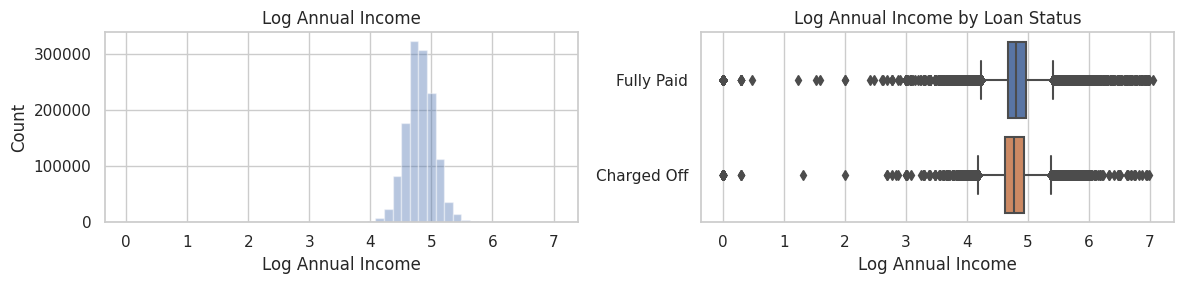

In [426]:
plot_var('log_annual_inc', 'Log Annual Income', continuous=True)

In [427]:
loans.groupby('loan_status')['log_annual_inc'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,263683.0,4.781405,0.241729,0.0,4.633479,4.778158,4.929424,6.977724
Fully Paid,1060284.0,4.820220,0.248674,0.0,4.672107,4.812920,4.968488,7.041361



Individuals with higher incomes tend to liquidate their debts, as shown by the graph and confirmed through the comparison table.


# 5.11 - Verification_status
Indicate income validation  status by Creditas, other institution ( Source Verified), or not verified.

In [428]:

loans['verification_status'].value_counts(dropna=False)


Source Verified    512494
Verified           411999
Not Verified       399474
Name: verification_status, dtype: int64

# 5.12 - Issue_d
Indicate the month in which the loan was provided.

Once this feature occurs after loan analysis, it won't be included in the model. However, it will serve to train and test the model and discarded it before the conclusion of the final model.

# 5.13 - Purpose
refers to the reason for the loan application

In [429]:
loans['purpose'].value_counts()

debt_consolidation    767683
credit_card           291346
home_improvement       85924
other                  76404
major_purchase         28908
medical                15254
small_business         15192
car                    14349
moving                  9312
vacation                8912
house                   7148
wedding                 2294
renewable_energy         915
educational              326
Name: purpose, dtype: int64

In [430]:
# Statistical Analysis for charge off by the purpose
loans.groupby('purpose')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off'].sort_values()


purpose
wedding               0.121622
car                   0.146003
credit_card           0.168837
educational           0.171779
home_improvement      0.176400
major_purchase        0.185208
vacation              0.190754
other                 0.210002
debt_consolidation    0.211081
medical               0.217320
house                 0.218942
moving                0.233033
renewable_energy      0.236066
small_business        0.296077
Name: loan_status, dtype: float64

29.6% of loans provided for small businesses possess charge-offs. It is a detail that must be considered during loan analysis.

# 5.14 - Title  
refers to the loan title provided by the borrower

In [431]:

loans['title'].describe()

count                1307310
unique                 61682
top       Debt consolidation
freq                  648322
Name: title, dtype: object

In [432]:
loans['title'].value_counts().head(10)

Debt consolidation         648322
Credit card refinancing    245976
Home improvement            73497
Other                       65307
Major purchase              23529
Debt Consolidation          15695
Medical expenses            13276
Business                    11526
Car financing               10984
Vacation                     7893
Name: title, dtype: int64

Most of this data is also provided in the purpose column. Feature deleted.

In [433]:
loans.drop('title', axis=1, inplace=True)

# 5.15 - Address  
Refers to the zip code and state address provided by the borrower during the application.  


In [434]:
loans['zip_code'].sample(10)


2157666    405xx
1133715    920xx
1271765    923xx
312810     277xx
1258458    453xx
207317     480xx
1077480    971xx
319470     370xx
73369      300xx
337803     325xx
Name: zip_code, dtype: object

In [435]:
loans['zip_code'].nunique()

942

In [436]:
loans['addr_state'].sample(15)

995367     GA
96675      CA
217303     NH
2008435    NC
1807066    NY
1974764    AZ
1972785    NY
2218033    NY
1222597    VA
1252159    PA
1910650    IL
281710     NC
523531     NY
59518      FL
233153     NJ
Name: addr_state, dtype: object

In [437]:
# Given the amount and irrelevance of the zip code for this purpose, I will delete it and proceed with the state table.
loans.drop(labels='zip_code', axis=1, inplace=True)

In [438]:
# Comparison of charge off by state

loans.groupby('addr_state')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off'].sort_values()

addr_state
DC    0.130841
VT    0.138815
ME    0.139100
IA    0.142857
OR    0.143670
NH    0.145620
CO    0.155064
WV    0.155187
WA    0.156801
SC    0.162231
WY    0.166725
KS    0.166848
MT    0.168566
UT    0.170187
CT    0.173712
RI    0.178528
IL    0.180611
GA    0.183340
WI    0.184165
ID    0.187424
MA    0.190701
CA    0.195513
AZ    0.195855
AK    0.196835
MN    0.197031
DE    0.197206
TX    0.197292
VA    0.198638
HI    0.201741
MI    0.202554
ND    0.202729
OH    0.205215
PA    0.207179
NC    0.207795
KY    0.209079
NJ    0.210642
SD    0.212344
MO    0.212417
MD    0.212693
NM    0.213234
TN    0.213650
IN    0.213672
FL    0.214269
NV    0.218995
NY    0.220016
LA    0.231026
OK    0.234446
AL    0.236279
AR    0.241355
NE    0.250720
MS    0.260748
Name: loan_status, dtype: float64

District of Columbia possess the lowest rate for charge off across the country with 13% and Mississippi with the highest 26.07%.


 # 5.16 - DTI  
Refers to the ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested Creditas loan, divided by the borrower’s self-reported monthly income.


In [439]:
loans['dti'].describe()

count    1.323597e+06
mean     1.827692e+01
std      1.115072e+01
min     -1.000000e+00
25%      1.178000e+01
50%      1.761000e+01
75%      2.405000e+01
max      9.990000e+02
Name: dti, dtype: float64

<ipython-input-440-357cf9a7f2e5>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(loans.loc[loans['dti'].notnull() & (loans['dti']<60), 'dti'], kde=False)


Text(0.5, 1.0, 'Debt-to-income Ratio')

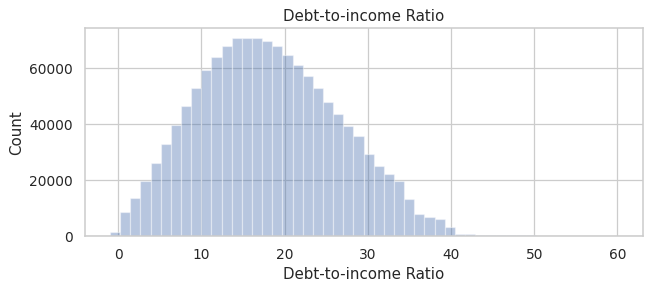

In [440]:
plt.figure(figsize=(8,3), dpi=90)
sns.distplot(loans.loc[loans['dti'].notnull() & (loans['dti']<60), 'dti'], kde=False)
plt.xlabel('Debt-to-income Ratio')
plt.ylabel('Count')
plt.title('Debt-to-income Ratio')

In [441]:
(loans['dti']>=60).sum()

1678

In [442]:
loans.groupby('loan_status')['dti'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,263614.0,20.164027,11.681323,0.0,13.54,19.76,26.31,999.0
Fully Paid,1059983.0,17.807607,10.964478,-1.0,11.42,17.10,23.44,999.0


# 5.17 - earliest_cr_line
Refers to the month the borrower's earliest reported credit line was opened.

In [443]:
loans['earliest_cr_line'].sample(5)

1822369    Oct-2002
332085     Jun-1994
1336674    Dec-2003
1188758    Oct-2002
1146697    Mar-2000
Name: earliest_cr_line, dtype: object

In [444]:
loans['earliest_cr_line'].isnull().any()

False

In [445]:
# To decrease the complexity of the analysis, I will consider only the year of the earliest credit line.
loans['earliest_cr_line'] = loans['earliest_cr_line'].apply(lambda s: int(s[-4:]))

In [446]:
loans['earliest_cr_line'].describe()

count    1.323967e+06
mean     1.998673e+03
std      7.608157e+00
min      1.934000e+03
25%      1.995000e+03
50%      2.000000e+03
75%      2.004000e+03
max      2.015000e+03
Name: earliest_cr_line, dtype: float64

<ipython-input-386-96cfd28b45d5>:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(loans.loc[loans[col_name].notnull(), col_name], kde=False, ax=ax1)


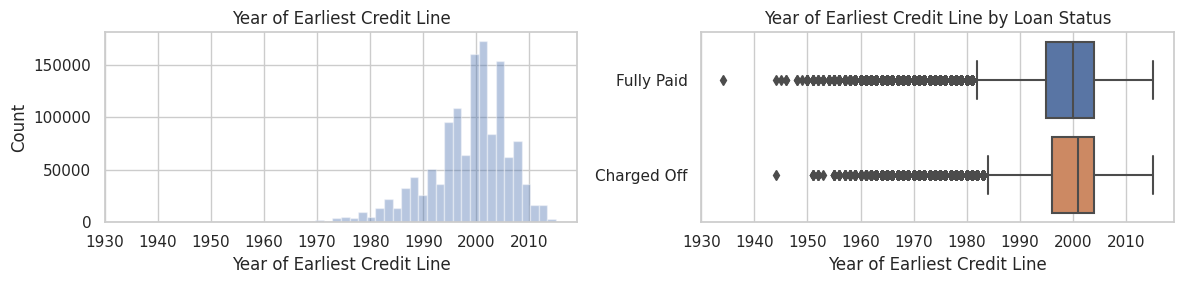

In [447]:
plot_var('earliest_cr_line', 'Year of Earliest Credit Line', continuous=True)

Short-line credit borrowers tend to default on payments.

# 5.18 fico_range_low, fico_range_high

Refers to the boundaries on fico score MIN to MAX

In [448]:
loans[['fico_range_low', 'fico_range_high']].describe()

,fico_range_low,fico_range_high
count,1.323967e+06,1.323967e+06
mean,6.961910e+02,7.001911e+02
std,3.185131e+01,3.185196e+01
min,6.250000e+02,6.290000e+02
25%,6.700000e+02,6.740000e+02
50%,6.900000e+02,6.940000e+02
75%,7.100000e+02,7.140000e+02
max,8.450000e+02,8.500000e+02


In [449]:
# Verifying if there is a linear correlation between the variables.

loans[['fico_range_low','fico_range_high']].corr()

,fico_range_low,fico_range_high
fico_range_low,1.0,1.0
fico_range_high,1.0,1.0


In [450]:
# To simplify the meaning of these two variables I will take the average on both and classify as the FICO score.
loans['fico_score'] = 0.5*loans['fico_range_low'] + 0.5*loans['fico_range_high']

In [451]:
loans.drop(['fico_range_high', 'fico_range_low'], axis=1, inplace=True)

<ipython-input-386-96cfd28b45d5>:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(loans.loc[loans[col_name].notnull(), col_name], kde=False, ax=ax1)


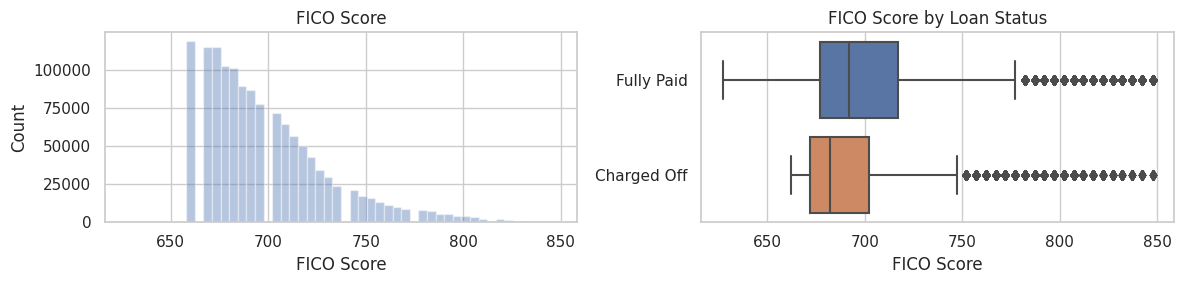

In [452]:
plot_var('fico_score', 'FICO Score', continuous=True)

In [453]:
loans.groupby('loan_status')['fico_score'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,263683.0,689.844237,25.939882,662.0,672.0,682.0,702.0,847.5
Fully Paid,1060284.0,700.266809,32.830740,627.0,677.0,692.0,717.0,847.5



Higher FICO score possess a lower risk of charge-off when compared with lower FICO score borrowers. There is an average difference of - 11 points for borrowers with default payments.

# 5.19 open_acc

Refers to the number of open credit lines in the borrower's credit file.

<ipython-input-454-0ad5dc464c55>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(loans['open_acc'], color='#5975A4')


Text(0.5, 1.0, 'Number of Open Credit Line')

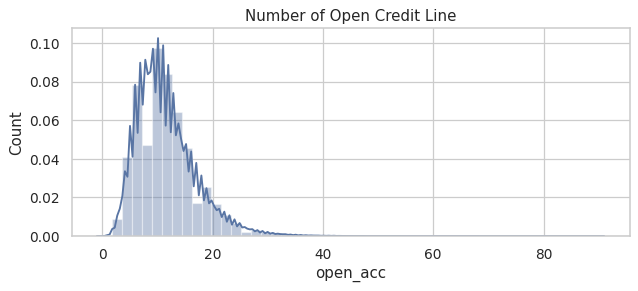

In [454]:
plt.figure(figsize=(8,3), dpi=90)
sns.distplot(loans['open_acc'], color='#5975A4')
plt.xlabel('open_acc')
plt.ylabel('Count')
plt.title('Number of Open Credit Line')

In [455]:
loans.groupby('loan_status')['open_acc'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,263683.0,11.896952,5.632352,0.0,8.0,11.0,15.0,76.0
Fully Paid,1060284.0,11.511480,5.423672,0.0,8.0,11.0,14.0,90.0


There is no data significance when comparing the credit lines with charges off.

# 5.20 pub_rec

Refers to the number of derogatory public records

In [456]:
loans['pub_rec'].value_counts().sort_index()

0.0     1100775
1.0      186951
2.0       23858
3.0        7230
4.0        2579
5.0        1240
6.0         621
7.0         276
8.0         157
9.0          81
10.0         56
11.0         39
12.0         26
13.0         17
14.0          5
15.0          9
16.0          5
17.0          3
18.0          6
19.0          5
20.0          3
21.0          6
22.0          2
23.0          1
24.0          1
25.0          1
28.0          3
34.0          1
37.0          1
40.0          1
46.0          1
47.0          1
49.0          2
54.0          1
61.0          1
63.0          1
86.0          1
Name: pub_rec, dtype: int64

In [457]:
loans.groupby('loan_status')['pub_rec'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,263683.0,0.245704,0.656501,0.0,0.0,0.0,0.0,86.0
Fully Paid,1060284.0,0.206304,0.585521,0.0,0.0,0.0,0.0,63.0


There is no data significance when comparing the public records with charge off.

# 5.21 revol_bal

Refers to total credit revolving balance.

In [458]:
loans['revol_bal'].describe()

count    1.323967e+06
mean     1.625953e+04
std      2.232950e+04
min      0.000000e+00
25%      5.947000e+03
50%      1.114800e+04
75%      1.977600e+04
max      2.904836e+06
Name: revol_bal, dtype: float64

In [459]:
# To make it easier I will apply a log transformation
loans['log_revol_bal'] = loans['revol_bal'].apply(lambda x: np.log10(x+1))

In [460]:
loans.drop('revol_bal', axis=1, inplace=True)

<ipython-input-386-96cfd28b45d5>:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(loans.loc[loans[col_name].notnull(), col_name], kde=False, ax=ax1)


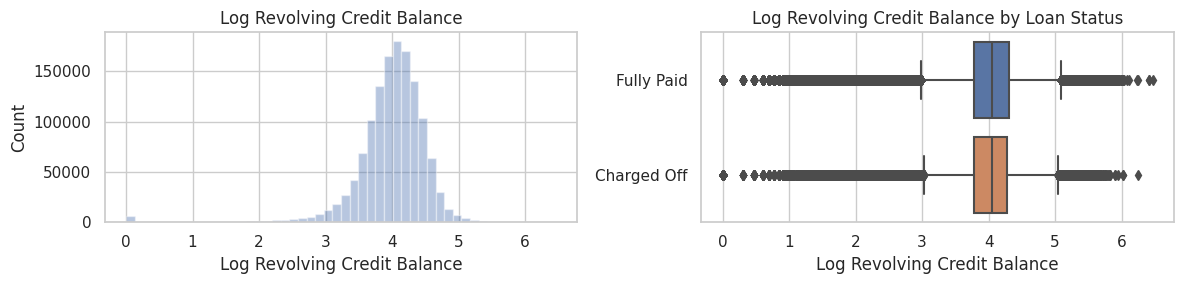

In [461]:
plot_var('log_revol_bal', 'Log Revolving Credit Balance', continuous=True)

In [462]:
loans.groupby('loan_status')['log_revol_bal'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,263683.0,3.986070,0.515435,0.0,3.777572,4.044579,4.281533,6.242223
Fully Paid,1060284.0,3.994243,0.536329,0.0,3.773640,4.047859,4.299921,6.463122


There is a insignificance difference in the means.


# 5.22 revol_util

Refers to  the revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit

In [463]:
loans['revol_util'].describe()

count    1.323133e+06
mean     5.187464e+01
std      2.452222e+01
min      0.000000e+00
25%      3.350000e+01
50%      5.230000e+01
75%      7.080000e+01
max      8.923000e+02
Name: revol_util, dtype: float64

<ipython-input-386-96cfd28b45d5>:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(loans.loc[loans[col_name].notnull(), col_name], kde=False, ax=ax1)


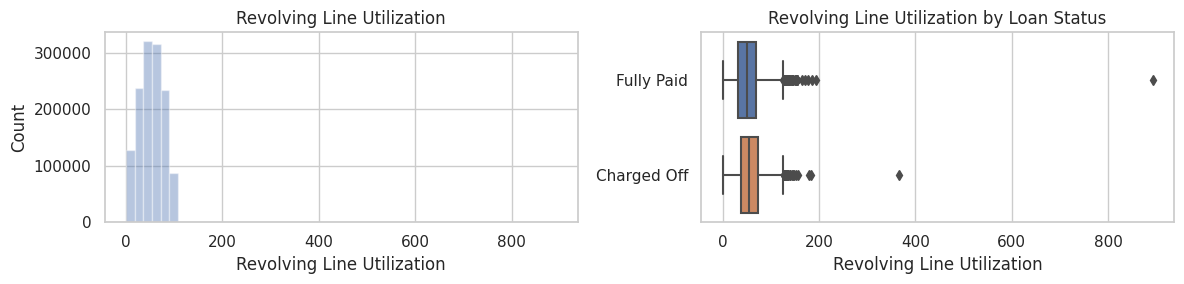

In [464]:
plot_var('revol_util', 'Revolving Line Utilization', continuous=True)

In [465]:
loans.groupby('loan_status')['revol_util'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,263508.0,54.823084,23.866268,0.0,37.5,55.6,73.2,366.6
Fully Paid,1059625.0,51.141421,24.627908,0.0,32.6,51.4,70.1,892.3


# 5.23 total_acc

Refers to the total number of credit lines currently in the borrower's credit file

<ipython-input-466-aab6422abff8>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(loans['total_acc'], color='#5975A4')


Text(0.5, 1.0, 'Total Number of Credit Lines')

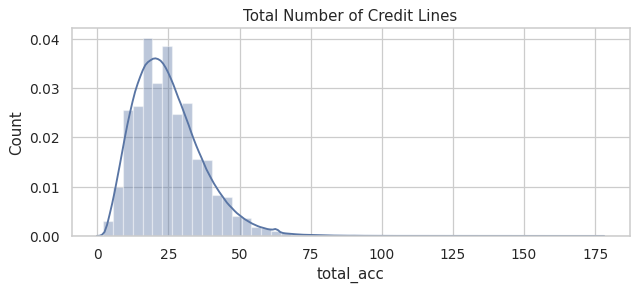

In [466]:
plt.figure(figsize=(8,3), dpi=90)
sns.distplot(loans['total_acc'], color='#5975A4')
plt.xlabel('total_acc')
plt.ylabel('Count')
plt.title('Total Number of Credit Lines')

# 5.24 application_type

Refers to whether the loan is an individual application or a joint application with two co-borrowers.

In [467]:
loans['application_type'].value_counts()

Individual    1298851
Joint App       25116
Name: application_type, dtype: int64

In [468]:
loans.groupby('application_type')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']

application_type
Individual    0.198254
Joint App     0.246098
Name: loan_status, dtype: float64

Joint Applications are most likely to charge off.

# 5.25 mort_acc

Refers to Number of mortgage accounts.

In [469]:
loans['mort_acc'].describe()

count    1.276686e+06
mean     1.672407e+00
std      2.003302e+00
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+00
75%      3.000000e+00
max      5.100000e+01
Name: mort_acc, dtype: float64

In [470]:
loans['mort_acc'].value_counts().head(10)

0.0    515526
1.0    222061
2.0    185473
3.0    136907
4.0     93432
5.0     56849
6.0     32156
7.0     16677
8.0      8290
9.0      4242
Name: mort_acc, dtype: int64

In [471]:
loans.groupby('loan_status')['mort_acc'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,256797.0,1.372979,1.828514,0.0,0.0,1.0,2.0,29.0
Fully Paid,1019889.0,1.747800,2.038039,0.0,0.0,1.0,3.0,51.0


Borrowers with several mortgage accounts are more likely to fully pay their loans

# 6. Pre Processing part II

## 6.1 Binary transformation for loan status

0 = Fully Paid
1 = Charge Off

In [472]:
loans['charged_off'] = (loans['loan_status'] == 'Charged Off').apply(np.uint8)
loans.drop('loan_status', axis=1, inplace=True)

## 6.2 Engineering Dummy Var

In [473]:
loans.shape


(1323967, 26)

In [474]:
# NaN will be created to replace any missing values for the categorical Var. To initiate the process is required to check NaN values.
missing_values = loans.isnull().mean().sort_values(ascending=False)

In [475]:

missing_fractions = missing_fractions.reindex(missing_values.index)
print(missing_values[missing_fractions > 0])

emp_length              0.058356
mort_acc                0.035712
revol_util              0.000630
pub_rec_bankruptcies    0.000526
dti                     0.000279
dtype: float64


In [476]:
# No missing values were found. Generating dummy var for cat variables.
print(loans.columns)

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'sub_grade',
       'emp_length', 'home_ownership', 'verification_status', 'issue_d',
       'purpose', 'addr_state', 'dti', 'earliest_cr_line', 'open_acc',
       'pub_rec', 'revol_util', 'total_acc', 'initial_list_status',
       'application_type', 'mort_acc', 'pub_rec_bankruptcies', 'jobtime',
       'log_annual_inc', 'fico_score', 'log_revol_bal', 'charged_off'],
      dtype='object')


In [477]:
loans = pd.get_dummies(loans, columns=['sub_grade', 'home_ownership', 'verification_status', 'purpose', 'addr_state', 'initial_list_status', 'application_type'], drop_first=True)

In [478]:
loans.shape

(1323967, 123)

In [479]:
# Analyze the new dummy var in the data
loans.sample(5)

,loan_amnt,term,int_rate,installment,emp_length,issue_d,dti,earliest_cr_line,open_acc,pub_rec,revol_util,total_acc,mort_acc,pub_rec_bankruptcies,jobtime,log_annual_inc,fico_score,log_revol_bal,charged_off,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_A5,sub_grade_B1,sub_grade_B2,sub_grade_B3,sub_grade_B4,sub_grade_B5,sub_grade_C1,sub_grade_C2,sub_grade_C3,sub_grade_C4,sub_grade_C5,sub_grade_D1,sub_grade_D2,sub_grade_D3,sub_grade_D4,sub_grade_D5,sub_grade_E1,sub_grade_E2,sub_grade_E3,sub_grade_E4,sub_grade_E5,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_IA,addr_state_ID,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_ND,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,initial_list_status_w,application_type_Joint App
717073,7000.0,36,7.39,217.40,3.0,Apr-2016,12.00,2009,6.0,0.0,84.0,12.0,1.0,0.0,3.0,4.518527,717.0,3.656002,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
419621,8000.0,36,15.59,279.64,3.0,Jan-2015,17.04,1985,19.0,1.0,32.8,32.0,1.0,1.0,3.0,4.653222,662.0,3.753736,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
212310,10875.0,60,17.57,273.62,4.0,Jul-2015,20.58,1993,5.0,1.0,48.0,33.0,5.0,1.0,4.0,4.785337,672.0,3.603144,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
151004,9150.0,36,13.33,309.76,9.0,Sep-2015,35.67,1995,6.0,1.0,58.5,10.0,0.0,0.0,9.0,4.318084,672.0,4.377962,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1900264,20000.0,36,15.31,696.35,10.0,Oct-2012,16.49,1999,18.0,0.0,49.7,28.0,1.0,0.0,10.0,4.812920,697.0,4.212268,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


## 6.3 Train/Test split
<a id="6.3"></a>

To enhance the model's performance, the Training and test phase will be based on the month the loan was funded. On this approach, I will use previously funded loans to predict whether future loans will default.

In [480]:
loans['issue_d'].sample(5)

1315753    Mar-2014
1771613    Nov-2013
1239883    Jul-2014
1127308    Nov-2014
1235355    Jul-2014
Name: issue_d, dtype: object

In [481]:
# cheching NaN - missing values
loans['issue_d'].isnull().any()

False

In [482]:
# specifying the dates by converting the current format.
loans['issue_d'] = pd.to_datetime(loans['issue_d'])
loans['issue_d'].sample(5)

126999    2015-10-01
1794140   2013-10-01
2069519   2017-12-01
1861677   2013-04-01
1792285   2013-10-01
Name: issue_d, dtype: datetime64[ns]

In [483]:
# It seems that specifying the dates will set up for the first day of the month.
loans['issue_d'].describe()

<ipython-input-483-bde71530e9c8>:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  loans['issue_d'].describe()


count                 1323967
unique                    138
top       2016-03-01 00:00:00
freq                    48937
first     2007-06-01 00:00:00
last      2018-12-01 00:00:00
Name: issue_d, dtype: object

Text(0.5, 1.0, 'Loans Funded per Year')

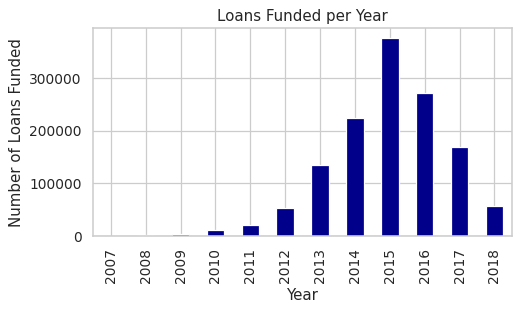

In [484]:
# Diving into the data. Sample distribution.
plt.figure(figsize=(6,3), dpi=90)
loans['issue_d'].dt.year.value_counts().sort_index().plot.bar(color='darkblue')
plt.xlabel('Year')
plt.ylabel('Number of Loans Funded')
plt.title('Loans Funded per Year')

In [485]:
# The Test will be compounded by the most recent loans. the TOP 10%
loans_train = loans.loc[loans['issue_d'] <  loans['issue_d'].quantile(0.9)]
loans_test =  loans.loc[loans['issue_d'] >= loans['issue_d'].quantile(0.9)]

In [486]:
# Checking Partitions
print('Count loans in the partition:   ', loans_train.shape[0] + loans_test.shape[0])
print('Count of loans in the full dataset:', loans.shape[0])

Count loans in the partition:    1323967
Count of loans in the full dataset: 1323967


In [487]:
loans_test.shape[0] / loans.shape[0]

0.10140207422088315

Partition confirmed with 10.1%. loans df not longer necessary. deleted

In [488]:
del loans

In [489]:
# Statistical Analysis for issues_d for Train & Test sets
loans_train['issue_d'].describe()

<ipython-input-489-f83a707f1bca>:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  loans_train['issue_d'].describe()


count                 1189714
unique                    120
top       2016-03-01 00:00:00
freq                    48937
first     2007-06-01 00:00:00
last      2017-06-01 00:00:00
Name: issue_d, dtype: object

In [490]:
loans_test['issue_d'].describe()

<ipython-input-490-dc8caa664ca9>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  loans_test['issue_d'].describe()


count                  134253
unique                     18
top       2017-08-01 00:00:00
freq                    15488
first     2017-07-01 00:00:00
last      2018-12-01 00:00:00
Name: issue_d, dtype: object

In [491]:
# The training set is compounded by a windown of 10 years (2007-2017) and test with 1 year period (2017-2018).
# issue_d variable must to be deleted, once is not part of loan analysis process.
loans_train.drop('issue_d', axis=1, inplace=True)
loans_test.drop('issue_d', axis=1, inplace=True)

In [492]:
#correlating the Variables predictor and response
y_train = loans_train['charged_off']
y_test = loans_test['charged_off']


In [493]:
X_train = loans_train.drop('charged_off', axis=1)
X_test = loans_test.drop('charged_off', axis=1)

In [494]:
del loans_train, loans_test

# 7. Linear Dependence of Charge-off on the Predictors
<a id="7"></a>

Person correlation was performed on the training set for statistical significance on F:statistic and P:value

In [495]:
linear_dep = pd.DataFrame()

In [496]:
#person correlation
for col in X_train.columns:
    linear_dep.loc[col, 'pearson_corr'] = X_train[col].corr(y_train)
linear_dep['abs_pearson_corr'] = abs(linear_dep['pearson_corr'])

In [497]:
#F:statistic
from sklearn.feature_selection import f_classif
for col in X_train.columns:
    mask = X_train[col].notnull()
    (linear_dep.loc[col, 'F'], linear_dep.loc[col, 'p_value']) = f_classif(pd.DataFrame(X_train.loc[mask, col]), y_train.loc[mask])

In [498]:
# sort pearson correlation by the absolute value results
linear_dep.sort_values('abs_pearson_corr', ascending=False, inplace=True)
linear_dep.drop('abs_pearson_corr', axis=1, inplace=True)

In [499]:
#index reset
linear_dep.reset_index(inplace=True)
linear_dep.rename(columns={'index':'variable'}, inplace=True)

In [500]:
#printing the top 25 results correlated with charge-off:
linear_dep.head(25)

,variable,pearson_corr,F,p_value
0,int_rate,0.260863,86871.085817,0.0
1,term,0.183030,41234.871734,0.0
2,fico_score,-0.131788,21028.120197,0.0
3,dti,0.100967,12252.291019,0.0
4,mort_acc,-0.072478,6032.884561,0.0
5,sub_grade_A4,-0.065623,5145.446621,0.0
6,sub_grade_A5,-0.065574,5137.768892,0.0
7,log_annual_inc,-0.065086,5061.255440,0.0
8,sub_grade_A2,-0.063229,4775.472562,0.0
9,home_ownership_RENT,0.062575,4676.756503,0.0


Following the Pearson correlation, charge-off factors are given by the following variables: interest rate, loan period (term), FICO score, debt-to-income ratio, number of mortgages, income, loan grade, and the loan amount.

For the least influencing factors, we have:


In [501]:
linear_dep.tail(25)

,variable,pearson_corr,F,p_value
96,addr_state_MA,-0.004150,20.495208,0.000006
97,addr_state_PA,0.004122,20.212911,0.000007
98,purpose_house,0.004101,20.009367,0.000008
99,addr_state_MO,0.003797,17.155245,0.000034
100,addr_state_MT,-0.003766,16.875464,0.000040
101,addr_state_WY,-0.003654,15.887744,0.000067
102,addr_state_NC,0.003401,13.758059,0.000208
103,addr_state_KY,0.003213,12.282665,0.000457
104,addr_state_RI,-0.003085,11.321806,0.000766
105,addr_state_NM,0.002658,8.407010,0.003738


Apparently, borrower's state, loan purposes, and revol_Bal do not influence the behavior of the model.  

# 8. Model Training and Testing
<a id="8"></a>

The deployment of ML pipeline will be performed through one or more tasks based on the requirements of each model.

1. Manipulation of NaN values.
2. Dimension reduction through LDA
3. Data Standardization
4. Model Selection

The model evaluation will be performed using a cross-validated scoree AUROC on the training set.

1. Random forest
2. Logistic regression with SGD training

Fine-tuning will be performed on each model for competition on the best performance, and once selected, I will tune the hyperparameters in the champion model.




In [502]:
!pip install sklearn

In [503]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV

## 8.1 Random forest



In [504]:
from sklearn.ensemble import RandomForestClassifier

In [505]:
pipeline_rfc = Pipeline([
    ('impute', SimpleImputer(copy=False)),
    ('model', RandomForestClassifier(n_jobs=-1, random_state=1))
])

In [506]:
param_grid_rfc = {
    'model__n_estimators': [50] # 50 randomic threes
}

In [507]:
grid_rfc = GridSearchCV(estimator=pipeline_rfc, param_grid=param_grid_rfc, scoring='roc_auc', n_jobs=-1, pre_dispatch='2*n_jobs', cv=5, verbose=1, return_train_score=False)

In [508]:
grid_rfc.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('impute', SimpleImputer(copy=False)),
                                       ('model',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=1))]),
             n_jobs=-1, param_grid={'model__n_estimators': [50]},
             scoring='roc_auc', verbose=1)

In [509]:
#AUROC Score fo RFC
grid_rfc.best_score_

0.6952733707095746

 = > 69.5%

## 8.2 Logistic Regression with SGD



In [510]:
from sklearn.linear_model import SGDClassifier

In [511]:
# ML PIPELINE
pipeline_sgdlogreg = Pipeline([
    ('impute', SimpleImputer(copy=False)),
        ('model', SGDClassifier(loss='log', max_iter=1000, tol=1e-3, random_state=1, warm_start=True))
])

In [512]:
param_grid_sgdlogreg = {
    'model__alpha': [10**-5, 10**-2, 10**1],
    'model__penalty': ['l1', 'l2']
}

In [513]:
grid_sgdlogreg = GridSearchCV(estimator=pipeline_sgdlogreg, param_grid=param_grid_sgdlogreg, scoring='roc_auc', n_jobs=-1, pre_dispatch='2*n_jobs', cv=5, verbose=1, return_train_score=False)

In [514]:
grid_sgdlogreg.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('impute', SimpleImputer(copy=False)),
                                       ('model',
                                        SGDClassifier(loss='log',
                                                      random_state=1,
                                                      warm_start=True))]),
             n_jobs=-1,
             param_grid={'model__alpha': [1e-05, 0.01, 10],
                         'model__penalty': ['l1', 'l2']},
             scoring='roc_auc', verbose=1)

In [515]:
grid_sgdlogreg.best_score_

0.6746578397273844

In [516]:
grid_sgdlogreg.best_params_

{'model__alpha': 0.01, 'model__penalty': 'l1'}

= > 67.45%

# 8.3 Fine Tune hyperparameters
<a id="8.3"></a>

There is a reference for the application in this model to reduce the number of variables so the algorithm can best perform ([Indice](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm#Dimension_reduction)). LDA will be deployed to reduce the dimension




In [526]:
print('Cross-validated AUROC scores')
print(grid_rfc.best_score_, '- Random forest')
print(grid_sgdlogreg.best_score_, '- Logistic regression')


Cross-validated AUROC scores
0.6952733707095746 - Random forest
0.6746578397273844 - Logistic regression


In [529]:
# the Champion model is random forest
#From now on I will fine tune the hyperparameters
param_grid_rfc = {
    ' model__n_estimators': [50] # 50 randomic threes
}

print(param_grid_rfc)

{' model__n_estimators': [50]}


In [536]:
grid_rfc = GridSearchCV(estimator=Pipeline(steps=[('impute', SimpleImputer(copy=False)),
                ('model', RandomForestClassifier(n_jobs=-1, random_state=1))]),
                param_grid={'model__n_estimators': [100, 200, 300]})

In [537]:
grid_rfc.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('impute', SimpleImputer(copy=False)),
                                       ('model',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=1))]),
             param_grid={'model__n_estimators': [100, 200, 300]})

In [539]:
grid_rfc.best_score_

0.8032182513116812

Great! The performance model increased by 11% on its accuracy.


## 8.4 Test set evaluation
<a id="8.5"></a>

In [540]:
# Initianting the process to test the chosen model on the most recent data)
from sklearn.metrics import roc_auc_score

In [545]:
y_score = grid_sgdlogreg.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_score)

0.6655754986933805

= > 66.55%


# 9 - Conclusion
<a id="8.5"></a>

For companies like Creditas, predicting loan default with high accuracy is very important to promote and sustain financial growth, mitigating the risks involved in the business.

During the execution of this project, it was possible to extract insights about customer behavior and factors influencing charge-off loans, enhancing the decision-making process. The use of data analysis techniques and machine learning algorithms helped us identify the mechanisms behind default payments on loans funded by Creditas. The machine learning model's performance must be improved, although it can provide a certain level of precision in the likelihood of a payment default during the loan analysis process.

Through the statistical analysis process, the most critical variables identified for predicting charge-off are: Interest rates, loan term, FICO score, and DTI (Debt to Income Ratio).

As a suggestion for improvements:

I recommend using other algorithms to identify the best performer once two algorithms (Logistic Regression and Random Forest) are insufficient to evaluate and assess the better prediction model.